# Visualize the change of brightness of box

## procedure
- 1. import csv file and get box ground truth
- 2. organize sequential data 
- 3. background subtraction

### import library

In [1]:
import csv 
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import cv2
import glob
import re

### load data

In [2]:
def loadData(max_num_bbox,max_num_class,bboxFile,classFile):
    """load data from csv file

    Args:
        max_num_bbox (int): max number of bboxes
        max_num_class (int): max number of classes
        bboxFile (string):bbox file name
        classFile (string): class file name

    Returns:
        dataBbox, dataClass(list) : bbox and class data
    """
    # make column header
    unitColumn = ["frameIndex","left","top","width","height"]*max_num_bbox
    unitColumnClass = ["frameIndex","label"]*max_num_class
    col_namesBbox = [ "{i}-{name}".format(i=i,name=unitColumn[i]) for i in range(len(unitColumn)) ]
    col_namesClass = [ "{i}-{name}".format(i=i,name=unitColumnClass[i]) for i in range(len(unitColumnClass)) ]
    dfBbox = pd.read_csv(filepath_or_buffer=bboxFile,names=col_namesBbox)
    dfBbox = dfBbox.fillna(-2) # fill none in dataFrame with -1
    dfClass = pd.read_csv(filepath_or_buffer=classFile,names=col_namesClass)
    dfClass = dfClass.fillna(-2)
    dataBbox = dfBbox.values
    dataClass = dfClass.values
    dfClass[:3]
    return dataBbox, dataClass

In [3]:
rootDir = r"C:\Users\kawaw\data_tracking\0119\objectTracking\ball_box\csv\gt"
bboxFile_left = os.path.join(rootDir,"bbox_left_gt.csv")
bboxFile_right = os.path.join(rootDir,"bbox_right_gt.csv")
classFile_left = os.path.join(rootDir,"label_left_gt.csv")
classFile_right = os.path.join(rootDir,"label_right_gt.csv")
num_bbox_left = 100
num_class_left = 300
num_bbox_right = 100
num_class_right = 300

bbox_gt_left,class_gt_left = loadData(max_num_bbox=num_bbox_left,max_num_class=num_class_left,bboxFile=bboxFile_left,classFile=classFile_left)
bbox_gt_right,class_gt_right = loadData(max_num_bbox=num_bbox_right,max_num_class=num_class_right,bboxFile=bboxFile_right,classFile=classFile_right)

In [4]:
def checkDetection(dataClass):
    numTime = dataClass.shape[0]#time steps
    numData = dataClass.shape[1]//2#number of detection
    ret=[]
    for i in range(numTime):
        isDetected=False
        for j in range(numData):
            if dataClass[i,j*2+1]>=0:
                isDetected=True
                break
        ret.append(isDetected)
    print(ret)
    return ret

retDetection_gt_left = checkDetection(dataClass=class_gt_left) #retDetection:whether object detected
retDetection_gt_right = checkDetection(dataClass=class_gt_right) #retDetection:whether object detected

[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, Tru

In [5]:
def array2dict(dataBbox,dataClass,retDetection)-> dict:
    """convert np.array to dict

    Args:
        dataBbox (np.array): sequence data of each detections
        dataClass (np.array): class label transition. if label chnage from 0 or 1 to -1, lost
        retDetection (np.array): [True or False, ,,,, ] if detected -> True

    Returns:
        data(dict): {"ball-1":[[frameIndex,left,top,width,height],,,],"box-1":,,,}
    """
    #copy data
    dataBboxCopy = dataBbox.copy()
    dataClassCopy = dataClass.copy()
    numBbox = dataBbox.shape[1]//5 #number of detections
    classLabel = []
    counterBall = 1
    counterBox = 1
    data = dict()
    numTime = dataClass.shape[0] #number of time steps
    numData = dataClass.shape[1]//2 #number of total detections
    for i in range(numData): #num of data
        counterDetection=0
        #print(f"{i}-th objects")
        tempClassData = dataClassCopy[:,i*2:(i+1)*2] #get data of [frameIndex, classLabel]
        #tempBboxData = dataBboxCopy[:,]
        boolStart=False #start signal
        boolBall = False #ball detection
        boolBox = False #box detection
        bboxes=[]
        for j in range(numTime): #number of sequence
            #print(f"{j}-th time-step :: {tempClassData[j,1]} :: {counterDetection}")
            #print(f"counterDetection :: {counterDetection}")
            #print(f"isBall:{boolBall},isBox:{boolBox}")
            numObjects=0 #number of detected objects
            if (tempClassData[j,1]>=0): #detection data is available
                boolStart=True
                Ball = int(tempClassData[j,1])==0
                Box = int(tempClassData[j,1])==1
                if Ball:
                    print("Ball")
                    # move to available data
                    while(dataBboxCopy[counterDetection,numObjects*5] < 0):
                        numObjects += 1
                    #print(f"numberObjects : {numObjects}")
                    bboxes.append(dataBboxCopy[counterDetection,numObjects*5:(numObjects+1)*5].tolist())
                    boolBall=True #ball detected
                    # change data to -1,-1,-1,-1,-1
                    for k in range(5):
                        dataBboxCopy[counterDetection,numObjects*5+k] =-1
                elif Box:
                    print("Box")
                    # move to available data
                    while(dataBboxCopy[counterDetection,numObjects*5] < 0):
                        numObjects += 1
                    #print(f"numberObjects : {numObjects}")
                    bboxes.append(dataBboxCopy[counterDetection,numObjects*5:(numObjects+1)*5].tolist())
                    boolBox=True
                    # change data to -1,-1,-1,-1,-1
                    for k in range(5):
                        dataBboxCopy[counterDetection,numObjects*5+k] =-1
            else: #detection data is not available
                if boolStart: #already started
                    break
            #if increment counter of bbox
            if retDetection[j]:
                counterDetection+=1
        print(f"isBall:{boolBall},isBox:{boolBox}")
        if boolBall: #ball detection
            data[f"Ball-{counterBall}"] = bboxes
            counterBall+=1
        elif boolBox: #box detection
            data[f"Box-{counterBox}"] = bboxes
            counterBox+=1
    return data

In [6]:
dict_gt_left = array2dict(dataBbox=bbox_gt_left,dataClass=class_gt_left,retDetection=retDetection_gt_left)
dict_gt_right = array2dict(dataBbox=bbox_gt_right,dataClass=class_gt_right,retDetection=retDetection_gt_right)

Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
isBall:True,isBox:False
Box
Box
Box
Box
Box
Box
Box
Box
Box
Box
isBall:False,isBox:True
Box
Box
Box
Box
Box
isBall:False,isBox:True
Box
Box
Box
Box
Box
Box
Box
Box
Box
Box
Box
Box
Box
Box
Box
Box
Box
Box
Box
Box
Box
isBall:False,isBox:True
Box
Box
Box
Box
Box
Box
Box
Box
isBall:False,isBox:True
Box
Box
Box
isBall:False,isBox:True
Box
isBall:False,isBox:True
Box
Box
Box
Box
Box
Box
Box
Box
Box
Box
Box
Box
Box
Box
Box
Box
Box
Box
Box
Box
Box
Box
Box
Box
Box
Box
Box
Box
Box
Box


In [7]:
markers=['o','s','D','+','x','^','v','>','<','p','H','8']
lines = [" ","--"]
colors=["r","g","b","c","m","y","k","w"]
'''
'o': Circle
's': Square
'D': Diamond
'+': Plus sign
'x': X
'^': Upward-pointing triangle
'v': Downward-pointing triangle
'>': Right-pointing triangle
'<': Left-pointing triangle
'p': Pentagram (five-pointed star)
'H': Hexagon
'8': Octagon
'''

"\n'o': Circle\n's': Square\n'D': Diamond\n'+': Plus sign\n'x': X\n'^': Upward-pointing triangle\n'v': Downward-pointing triangle\n'>': Right-pointing triangle\n'<': Left-pointing triangle\n'p': Pentagram (five-pointed star)\n'H': Hexagon\n'8': Octagon\n"

In [8]:
#Ground Truth
def plotData(data,color,data_name,pos,fig,ax):
    numBall=0
    numBox=0
    for key in data:
        label = key.split("-")[0] #label : ball or box
        tempData = data[key]
        tempFrame = []
        tempPositionX = []
        tempPositionY = []
        for i in range(len(tempData)):
            tempFrame.append(tempData[i][0])
            centerX = tempData[i][1]+tempData[i][3]/2
            centerY = tempData[i][2]+tempData[i][4]/2
            tempPositionX.append(centerX)
            tempPositionY.append(centerY)
        if pos == "left":
            if data_name == "rawData":
                if (label=="Ball"):
                    ax[0][0].plot(tempFrame,tempPositionX,color=color,linestyle=" ",marker=markers[numBall%len(markers)]) #colors[numBall//len(colors)]
                    ax[1][0].plot(tempFrame,tempPositionY,color=color,linestyle=" ",marker=markers[numBall%len(markers)])
                    numBall += 1
                elif (label=="Box"):
                    ax[0][1].plot(tempFrame,tempPositionX,color=color,linestyle=" ",marker=markers[numBox%len(markers)])
                    ax[1][1].plot(tempFrame,tempPositionY,color=color,linestyle=" ",marker=markers[numBox%len(markers)])
                    numBox += 1
            else:    
                if (label=="Ball"):
                    ax[0][0].plot(tempFrame,tempPositionX,color=color,linestyle=" ",marker=markers[numBall%len(markers)],label=key+"-"+data_name) #colors[numBall//len(colors)]
                    ax[1][0].plot(tempFrame,tempPositionY,color=color,linestyle=" ",marker=markers[numBall%len(markers)])
                    numBall += 1
                elif (label=="Box"):
                    ax[0][1].plot(tempFrame,tempPositionX,color=color,linestyle=" ",marker=markers[numBox%len(markers)],label=key+"-"+data_name)
                    ax[1][1].plot(tempFrame,tempPositionY,color=color,linestyle=" ",marker=markers[numBox%len(markers)])
                    numBox += 1
        elif pos == "right":
            if data_name == "rawData":
                if (label=="Ball"):
                    ax[2][0].plot(tempFrame,tempPositionX,color=color,linestyle=" ",marker=markers[numBall%len(markers)]) #colors[numBall//len(colors)]
                    ax[3][0].plot(tempFrame,tempPositionY,color=color,linestyle=" ",marker=markers[numBall%len(markers)])
                    numBall += 1
                elif (label=="Box"):
                    ax[2][1].plot(tempFrame,tempPositionX,color=color,linestyle=" ",marker=markers[numBox%len(markers)])
                    ax[3][1].plot(tempFrame,tempPositionY,color=color,linestyle=" ",marker=markers[numBox%len(markers)])
                    numBox += 1

            else:
                if (label=="Ball"):
                    ax[2][0].plot(tempFrame,tempPositionX,color=color,linestyle=" ",marker=markers[numBall%len(markers)],label=key+"-"+data_name) #colors[numBall//len(colors)]
                    ax[3][0].plot(tempFrame,tempPositionY,color=color,linestyle=" ",marker=markers[numBall%len(markers)])
                    numBall += 1
                elif (label=="Box"):
                    ax[2][1].plot(tempFrame,tempPositionX,color=color,linestyle=" ",marker=markers[numBox%len(markers)],label=key+"-"+data_name)
                    ax[3][1].plot(tempFrame,tempPositionY,color=color,linestyle=" ",marker=markers[numBox%len(markers)])
                    numBox += 1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


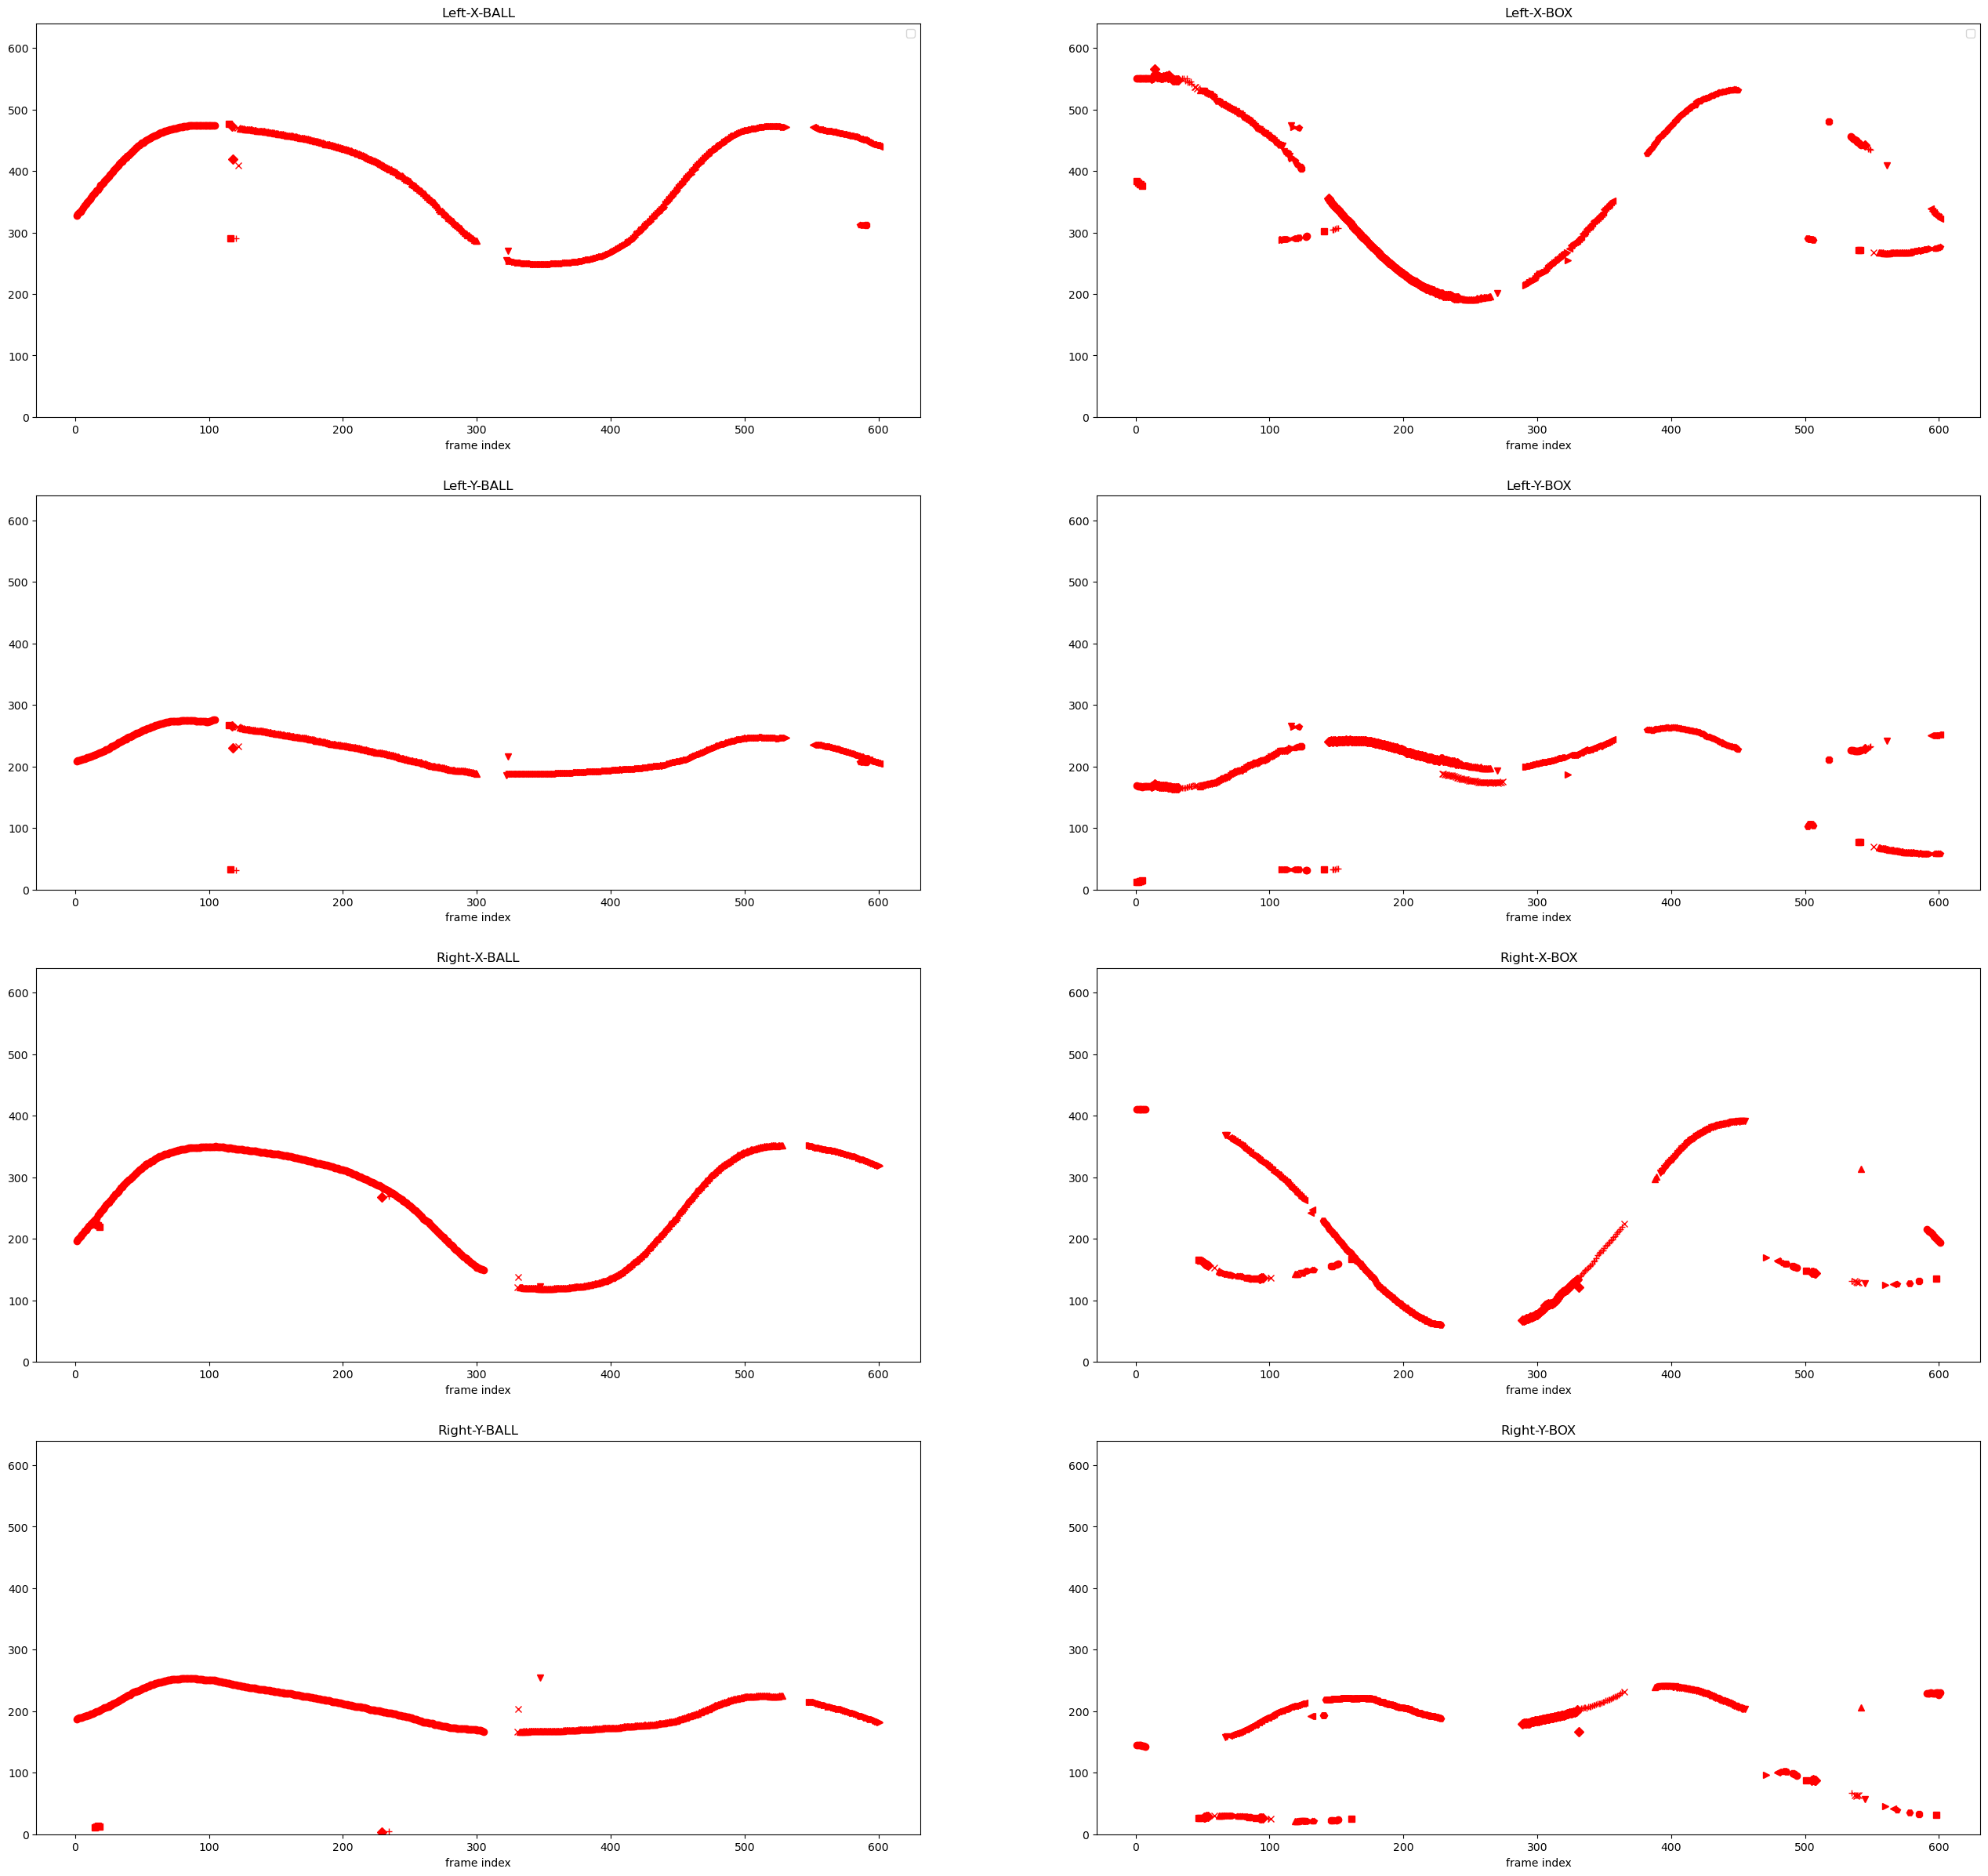

In [9]:
poss = ["Left","Right"]
types = ["BALL","BOX"]
axes = ["X","Y"]
titles = []
for pos in poss:
    for axis in axes:
        for type in types:
            titles.append(pos+"-"+axis+"-"+type)
fig,ax = plt.subplots(4,2,figsize=(32,30))
plotData(data=dict_gt_left,color="r",data_name="rawData",pos="left",fig=fig,ax=ax)
plotData(data=dict_gt_right,color="r",data_name="rawData",pos="right",fig=fig,ax=ax)
for i in range(4): #y
    for j in range(2): #x
        if i== 0:
            ax[i][j].legend()
        ax[i][j].set_ylim(0,640)
        ax[i][j].set_title(titles[i*2+j])
        ax[i][j].set_xlabel("frame index")
plt.show()

### bgs for box

#### Extract only box data

In [10]:
#Ground Truth
def getBoxData(data,pos):
    numBall=0
    numBox=0
    dict_frame = dict()
    dict_pos = dict()
    for key in data:
        label = key.split("-")[0] #label : ball or box
        tempData = data[key]
        tempFrame = []
        tempPositionX = []
        tempPositionY = []
        for i in range(len(tempData)):
            tempFrame.append(tempData[i][0])
            centerX = tempData[i][1]+tempData[i][3]/2
            centerY = tempData[i][2]+tempData[i][4]/2
            tempPositionX.append(centerX)
            tempPositionY.append(centerY)
        if pos == "left":
            if (label=="Box"):
                temp = []
                for i in range(len(tempFrame)):
                    temp.append([tempPositionX[i],tempPositionY[i]])
                dict_pos[numBox] = np.array(temp)
                dict_frame[numBox] = np.array(tempFrame)
                numBox += 1
        elif pos == "right":
            if (label=="Box"):
                temp = []
                for i in range(len(tempFrame)):
                    temp.append([tempPositionX[i],tempPositionY[i]])
                dict_pos[numBox] = np.array(temp)
                dict_frame[numBox] = np.array(tempFrame)
                numBox += 1
    
    return dict_frame, dict_pos

In [11]:
dict_frame, dict_pos = getBoxData(data=dict_gt_left,pos="left")

#### crop box data

In [12]:
def getCandidateArea(frame, dict_frame, dict_pos):
    target_pos = []
    for key in dict_frame:
        indexes = np.where(dict_frame[key]==frame)[0]
        if (len(indexes)>=1):
            for i in range(len(indexes)):
                target_pos.append(dict_pos[key][indexes[i]])
    return target_pos

In [13]:
a = np.array([1,2,2,3])
indexes = np.where(a==2)[0]
print(indexes)
print(len(indexes))

[1 2]
2


In [40]:
#set constant size
width = 150
height = 150
#binning
bool_bin = False
bool_optflow = True

# Open the video file
rootDir = r"C:\Users\kawaw\data_tracking\0119\objectTracking\ball_box"
video_path = 'ball_box_0119_left.mp4'
video_path = os.path.join(rootDir,video_path)
saveDir = r"C:\Users\kawaw\tracking_algorithm\bgs_box"
cap = cv2.VideoCapture(video_path)

# Check if the video file is opened successfully
if not cap.isOpened():
    print("Error: Could not open video file.")
    exit()

# Loop through the frames
counter = 1
while True:
    # Capture frame-by-frame
    ret, frame = cap.read()
    #print(frame.shape)
    # Check if the video is over
    if not ret:
        break

    #downsample image
    if bool_bin:
        # Downsample the image by half using bilinear interpolation
        frame = cv2.resize(frame, (frame.shape[0] // 2, frame.shape[1] // 2), interpolation=cv2.INTER_LINEAR)

    # For example, you can convert the frame to grayscale
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    #get candidate area
    target_pos = getCandidateArea(counter,dict_frame, dict_pos)
    #print(target_pos)
    if (len(target_pos)>=1):
        #downsampled image
        if bool_bin:
            xCenter = int(target_pos[0][0]//2)
            yCenter = int(target_pos[0][1]//2)
            left = int(min(frame.shape[0],max(0,xCenter-width/2/2)))
            right = int(max(left,min(frame.shape[0],xCenter+width/2/2)))
            top = int(min(frame.shape[1],max(0,yCenter-height/2/2)))
            bottom = int(max(top,min(frame.shape[1],yCenter+height/2/2)))
        else: #original image
            xCenter = int(target_pos[0][0])
            yCenter = int(target_pos[0][1])
            left = int(min(frame.shape[0],max(0,xCenter-width/2)))
            right = int(max(left,min(frame.shape[0],xCenter+width/2)))
            top = int(min(frame.shape[1],max(0,yCenter-height/2)))
            bottom = int(max(top,min(frame.shape[1],yCenter+height/2)))
        if (left<right and top<bottom):
            if counter == 1:
                previousFrame = gray_frame[top:bottom, left:right] 
            croppedFrame = gray_frame[top:bottom, left:right]
            if (previousFrame.shape[0] != croppedFrame.shape[0] or previousFrame.shape[1] != croppedFrame.shape[1]):
                maxWidth = max(previousFrame.shape[0],croppedFrame.shape[0])
                maxHeight = max(previousFrame.shape[1],croppedFrame.shape[1])
                print(maxWidth,maxHeight)
                previousFrame = cv2.resize(previousFrame, (maxWidth, maxHeight))
                croppedFrame = cv2.resize(croppedFrame, (maxWidth, maxHeight))
            if bool_optflow:#optical flow
                # Compute optical flow
                flow = cv2.calcOpticalFlowFarneback(previousFrame, croppedFrame, None, 0.5, 3, 15, 3, 5, 1.2, 0)
                # Compute the magnitude and angle of the flow vectors
                magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])
                # Create a mask to display the flow vectors
                mask_shape = list(previousFrame.shape)
                print(mask_shape)
                mask_shape = mask_shape+[3]
                mask_shape = tuple(mask_shape)
                print(mask_shape)
                mask = np.zeros_like(frame)
                mask[..., 0] = 255

                # Compute the direction of the flow vectors and display them on the original frame
                angle = angle * 180 / np.pi / 2
                mask[..., 1] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
                mask[..., 2] = 255
                flow_image = cv2.cvtColor(mask, cv2.COLOR_HSV2BGR)
                if counter >=2:
                    previousFrame = croppedFrame
                savePath = os.path.join(saveDir,f"{counter:03d}.png")
                cv2.imwrite(savePath,flow_image)
            else: #background subtraction
                diff_frame = cv2.absdiff(croppedFrame, previousFrame)
                inverted_frame = 255 - diff_frame
                edges = cv2.Canny(diff_frame, 50, 150)
                #print(previousFrame.shape)
                #print(croppedFrame.shape)
                #print(diff_frame.shape)
                if counter >=2:
                    previousFrame = croppedFrame
                savePath = os.path.join(saveDir,f"{counter:03d}.png")
                cv2.imwrite(savePath,edges)
            #cv2.imshow('Grayscale', diff_frame)
            # Wait for 'q' key to exit the loop
            if cv2.waitKey(25) & 0xFF == ord('q'):
                break
    counter += 1
# Release the video capture object and close all windows
cap.release()
cv2.destroyAllWindows()

[150, 150]
(150, 150, 3)


error: OpenCV(4.8.1) d:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.simd_helpers.hpp:94: error: (-2:Unspecified error) in function '__cdecl cv::impl::`anonymous-namespace'::CvtHelper<struct cv::impl::`anonymous namespace'::Set<3,-1,-1>,struct cv::impl::A0xc8d1a5f6::Set<3,4,-1>,struct cv::impl::A0xc8d1a5f6::Set<0,5,-1>,3>::CvtHelper(const class cv::_InputArray &,const class cv::_OutputArray &,int)'
> Unsupported depth of input image:
>     'VDepth::contains(depth)'
> where
>     'depth' is 6 (CV_64F)


#### make video frame images in a folder

In [31]:
import glob

import cv2
import os
import re

class MakeVideo():
    def __init__(self,imgsize,src,videoname):
        self.imgsize = imgsize
        self.src = src
        self.videoname = videoname
        self.main()

    def atoi(self,text):
        return int(text) if text.isdigit() else text

    def natural_keys(self,text):
        return [ self.atoi(c) for c in re.split(r'(\d+)', text) ]

    def main(self):
        img_array=[]
        for filename in sorted(glob.glob(f"{self.src}/*.png"), key=self.natural_keys):
            img = cv2.imread(filename)
            height, width, layers = img.shape
            size = (width, height)
            img_array.append(img)

        out = cv2.VideoWriter(self.videoname, cv2.VideoWriter_fourcc(*'mp4v'), 10.0, self.imgsize)

        for i in range(len(img_array)):
            out.write(img_array[i])
        out.release()

In [32]:
#switching
src_left = r'C:\Users\kawaw\tracking_algorithm\bgs_box'
videoname_left = r"C:\Users\kawaw\tracking_algorithm\bgs_box_edges.mp4"
imgsize = (150,150)
mkVideo_left = MakeVideo(imgsize=imgsize,src=src_left,videoname=videoname_left)